In [1]:
# https://arxiv.org/pdf/1703.09137.pdf
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'Init-inject'

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [3]:
DATASET_DIR = r'../../Datasets/Patches'
ALL_TRANSCRIPTS_PATH = f'{DATASET_DIR}/All.txt'
VALID_TRANSCRIPTS_PATH = f'{DATASET_DIR}/Validate.txt'
FONT_PATH = r'../../NomNaTong-Regular.ttf'

## Load and remove records with rare characters

In [4]:
from loader import DataImporter
dataset = DataImporter(DATASET_DIR, ALL_TRANSCRIPTS_PATH, min_length=1)
print(dataset)

Samples count (not include Latin letters, numbers, punctuations):
- Number of images found: 37836
- Number of labels found: 37836
- Number of unique characters: 7479
- Characters present: {'之': 7523, '以': 4796, '人': 3550, '月': 3446, '十': 3252, '不': 3145, '年': 3012, '帝': 2689, '有': 2541, '二': 2492, '其': 2449, '大': 2312, '日': 2260, '為': 2228, '等': 2082, '爲': 2018, '而': 1973, '國': 1946, '一': 1931, '軍': 1880, '王': 1872, '太': 1871, '公': 1830, '天': 1829, '子': 1792, '三': 1784, '官': 1783, '兵': 1778, '明': 1721, '曰': 1680, '於': 1629, '至': 1625, '使': 1597, '時': 1562, '者': 1561, '阮': 1550, '事': 1521, '臣': 1519, '也': 1498, '黎': 1409, '及': 1384, '文': 1374, '皇': 1359, '上': 1358, '如': 1352, '是': 1299, '行': 1258, '安': 1250, '五': 1240, '士': 1240, '中': 1217, '元': 1207, '四': 1199, '命': 1166, '下': 1165, '自': 1161, '民': 1120, '所': 1113, '宗': 1095, '書': 1047, '州': 1044, '六': 1029, '得': 1028, '道': 1015, '武': 1008, '于': 999, '生': 988, '都': 957, '吏': 946, '城': 939, '正': 922, '将': 907, '知': 899, '各': 889, '令': 8

## Data constants and input pipeline

In [5]:
HEIGHT, WIDTH = 432, 48
PADDING_CHAR = '[PAD]' 
START_CHAR = '[START]'
END_CHAR = '[END]' 

In [6]:
from loader import DataHandler
data_handler = DataHandler(
    dataset, 
    img_size = (HEIGHT, WIDTH), 
    padding_char = PADDING_CHAR,
    start_char = START_CHAR,
    end_char = END_CHAR
)

In [7]:
NUM_VALIDATE = DataImporter(DATASET_DIR, VALID_TRANSCRIPTS_PATH, min_length=1).size
MAX_LENGTH = data_handler.max_length
START_TOKEN = data_handler.start_token
END_TOKEN = data_handler.end_token
VOCAB_SIZE = data_handler.char2num.vocab_size()
BATCH_SIZE = 32

## Visualize the data

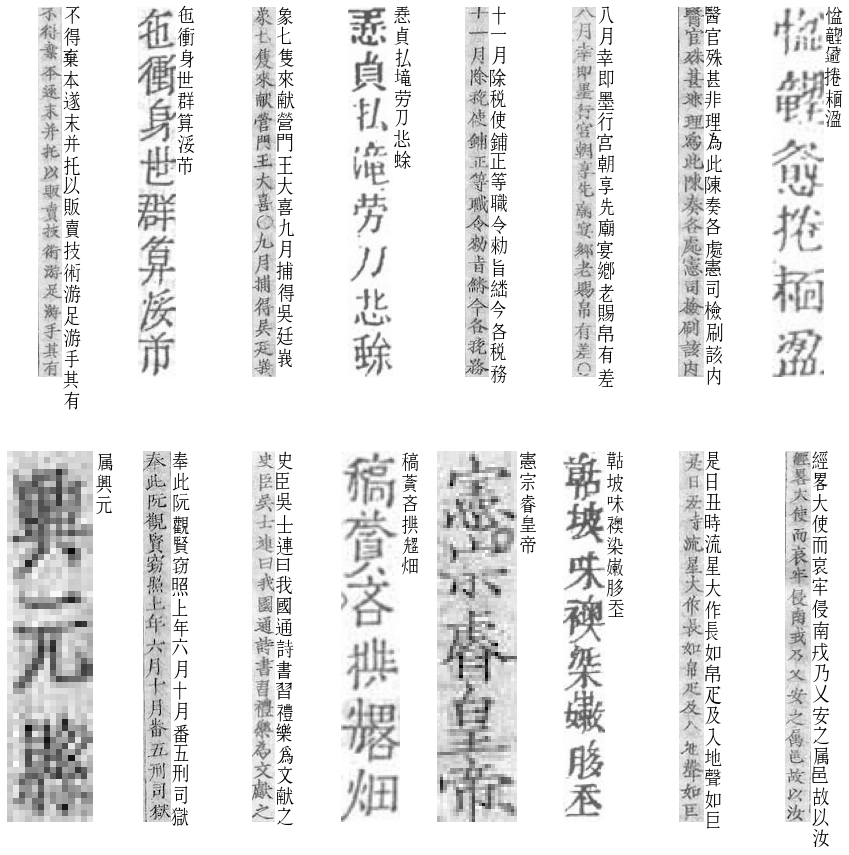

In [8]:
from visualizer import visualize_images_labels
visualize_images_labels(
    dataset.img_paths, 
    dataset.labels, 
    figsize = (15, 15),
    subplot_size = (2, 8),
    font_path = FONT_PATH
)

# Define model components

In [9]:
from tensorflow.keras.layers import Input, Embedding, Dense, GRU, Flatten
from layers import custom_cnn
EMBEDDING_DIM = 512
UNITS = 512

## The CNN block

In [10]:
def FeaturesExtractor(imagenet_model=None, imagenet_output_layer=None, name='FeaturesExtractor'):
    # CNN block
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (2, 2)}, 

            # Last Conv blocks with 2x2 kernel but without no padding and pooling layer
            'block5': {'num_conv': 2, 'filters': 512, 'pool_size': None}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before adding output to RNN
    cnn_output = Dense(UNITS, name='cnn_output')(Flatten()(x))
    return tf.keras.Model(inputs=image_input, outputs=cnn_output, name=name)

## The RNN block

In [11]:
def TextProcessor(features_shape, name='TextProcessor'):
    partial_seq_input = Input(shape=(MAX_LENGTH - 1,), dtype='int64', name='partial_caption')
    features_input = Input(shape=features_shape, name='image_features')
    rnn_output = GRU(UNITS, name='rnn_output')(
        Embedding(VOCAB_SIZE, EMBEDDING_DIM)(partial_seq_input), 
        initial_state = features_input
    )
    y_pred = Dense(VOCAB_SIZE, name='prediction')(rnn_output)
    return tf.keras.Model(inputs=[partial_seq_input, features_input], outputs=y_pred, name=name)

# Build the model

In [12]:
from models import get_imagenet_model, EarlyBindingCaptioner
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 3))
# imagenet_output_layer = 'block5_pool'
# imagenet_model.summary(line_length=100)

In [13]:
cnn_block = FeaturesExtractor(imagenet_model, imagenet_output_layer)
rnn_block = TextProcessor(cnn_block.output.shape[1:])
model = EarlyBindingCaptioner(cnn_block, rnn_block, data_handler)

In [14]:
cnn_block.summary(line_length=100)
print()
rnn_block.summary(line_length=100)

Model: "FeaturesExtractor"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 image (InputLayer)                          [(None, 432, 48, 3)]                    0              
                                                                                                    
 block1_conv1 (Conv2D)                       (None, 432, 48, 64)                     1792           
                                                                                                    
 block1_bn1 (BatchNormalization)             (None, 432, 48, 64)                     256            
                                                                                                    
 block1_relu1 (Activation)                   (None, 432, 48, 64)                     0              
                                                                

                                                                                                    
Total params: 9,246,011
Trainable params: 9,246,011
Non-trainable params: 0
____________________________________________________________________________________________________


# Training

In [15]:
train_idxs = list(range(dataset.size - NUM_VALIDATE))
valid_idxs = list(range(train_idxs[-1] + 1, dataset.size))
print('Number of training samples:', len(train_idxs))
print('Number of validate samples:', len(valid_idxs))

Number of training samples: 30259
Number of validate samples: 7577


In [16]:
import random
random.seed(2022)
random.shuffle(train_idxs)

# When run on a small RAM machine, you can set use_cache=False to 
# not run out of memory but it will slow down the training speed
train_tf_dataset = data_handler.prepare_tf_dataset(train_idxs, BATCH_SIZE, drop_remainder=True)
valid_tf_dataset = data_handler.prepare_tf_dataset(valid_idxs, BATCH_SIZE, drop_remainder=True)

## Callbacks

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 1e-3, # Change that less than 1e-3, will count as no improvement
    patience = 5, # Stop if no improvement after 5 epochs
    restore_best_weights = True, # Restore weights from the epoch with the best value
    verbose = 1
)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_lr = 1e-6, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Train the NomNaOCR dataset

In [18]:
from losses import MaskedLoss
from metrics import SequenceAccuracy, CharacterAccuracy, LevenshteinDistance
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [19]:
model.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = MaskedLoss(), 
    metrics = [ 
        SequenceAccuracy(), 
        CharacterAccuracy(),  
        LevenshteinDistance(normalize=True, name='lev_distance')
    ]
)

In [20]:
%%time
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = EPOCHS,
    callbacks = [reduce_lr_callback, early_stopping_callback],
    verbose = 1
).history

Epoch 1/100
945/945 [==============================] - 250s 239ms/step - loss: 4.8621 - seq_acc: 1.6534e-04 - char_acc: 0.0916 - lev_distance: 0.8174 - val_loss: 1.5456 - val_seq_acc: 0.0000e+00 - val_char_acc: 0.0952 - val_lev_distance: 0.7846 - lr: 2.0000e-04
Epoch 2/100
945/945 [==============================] - 214s 226ms/step - loss: 4.5836 - seq_acc: 0.0029 - char_acc: 0.1256 - lev_distance: 0.7833 - val_loss: 1.3810 - val_seq_acc: 0.0029 - val_char_acc: 0.1482 - val_lev_distance: 0.7756 - lr: 2.0000e-04
Epoch 3/100
945/945 [==============================] - 213s 225ms/step - loss: 4.4159 - seq_acc: 0.0042 - char_acc: 0.1472 - lev_distance: 0.7751 - val_loss: 1.3806 - val_seq_acc: 0.0036 - val_char_acc: 0.1556 - val_lev_distance: 0.7691 - lr: 2.0000e-04
Epoch 4/100
945/945 [==============================] - 212s 225ms/step - loss: 4.2444 - seq_acc: 0.0062 - char_acc: 0.1627 - lev_distance: 0.7647 - val_loss: 1.3413 - val_seq_acc: 0.0075 - val_char_acc: 0.1524 - val_lev_distance: 

## Save the training results

In [21]:
best_epoch = early_stopping_callback.best_epoch
print(f'- Loss on validation\t: {history["val_loss"][best_epoch]}')
print(f'- Sequence accuracy\t: {history["val_seq_acc"][best_epoch]}')
print(f'- Character accuracy\t: {history["val_char_acc"][best_epoch]}')
print(f'- Levenshtein distance\t: {history["val_lev_distance"][best_epoch]}')

- Loss on validation	: 1.2246545553207397
- Sequence accuracy	: 0.0190677959471941
- Character accuracy	: 0.2329501509666443
- Levenshtein distance	: 0.7089225649833679


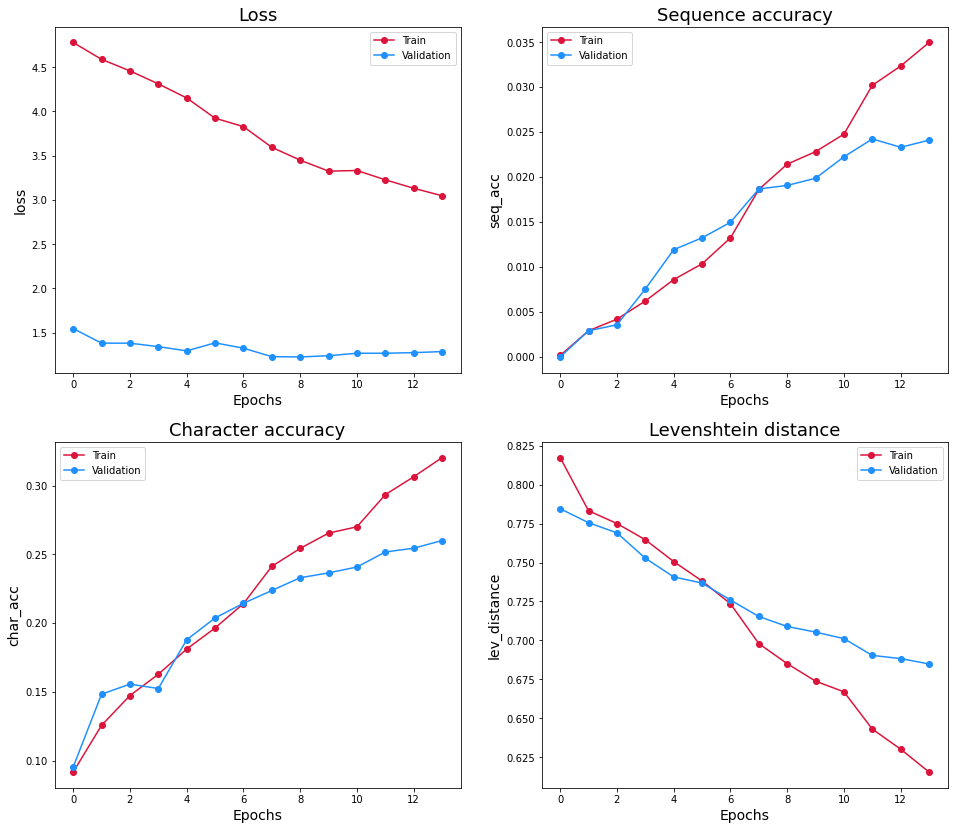

In [22]:
from visualizer import plot_training_results
plot_training_results(history, f'{APPROACH_NAME}.png')
model.cnn_block.save_weights(f'{APPROACH_NAME}_cnn.h5')
model.rnn_block.save_weights(f'{APPROACH_NAME}_rnn.h5')

# Inference

In [20]:
cnn_block = FeaturesExtractor(imagenet_model, imagenet_output_layer)
rnn_block = TextProcessor(cnn_block.output.shape[1:])
cnn_block.load_weights(f'NomNaOCR/NomNaOCR_{APPROACH_NAME}_cnn.h5')
rnn_block.load_weights(f'NomNaOCR/NomNaOCR_{APPROACH_NAME}_rnn.h5')

In [21]:
reset_model = EarlyBindingCaptioner(cnn_block, rnn_block, data_handler)
reset_model.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = MaskedLoss(), 
    metrics = [
        SequenceAccuracy(),
        CharacterAccuracy(),
        LevenshteinDistance(normalize=True, name='lev_distance')
    ]
)

## On test dataset

Batch 01:
- True: {1: '使通好執事迷而不反我是以有徃年之師帝遣', 2: '池有大蛇入見二十日上以砲旗皷制之賜月', 3: '非傾人宗祧若是其幾無所不至以致大明之疑', 4: '十一月戊辰朔日有食以裴時亨密奏故不之', 5: '使人追之不及十三日卯時克終自元軍回賊', 6: '冬十一月皇太子即皇帝位大赦以明年爲景', 7: '於民何以居人上宜早除之帝自知其然而心', 8: '使養之其人曰每月用藥所費百金三年方效王', 9: '一士王之時雖有守任然王以諸侯當國國人皆', 10: '安生王子國峻奪之公主㱕于國峻是月十五日', 11: '項郎尤鍾愛之立爲太子璉以是不平使人陰殺', 12: '其才品有高下之不同然亦莫不各得其人以', 13: '是龍鋌求爲太子帝欲許之廷臣議以爲不立長', 14: '取陶儼等三十六人廷試上親問以君師之道', 15: '日還國雖曰人謀之不滅是亦天運之有数也夫', 16: '之以本月十九日遷塟于御天之羙舍鄕二十', 17: '博覽副之卒定三年一貢為常例二月二十四', 18: '京恐為不便帝從之故有是命令明人著京', 19: '鄕人也以太祖起義六年癸卯冬十一月二', 20: '献六眸龟胷中有籒文二行群臣辨之成王以公', 21: '為阮朝且絶民之望李氏也秋七月二十二日', 22: '柰等二十員人入鳯\U000f0029堂帝自命題試之九日', 23: '府每以日燏子孫爲之如國康之於演州是也', 24: '納之乃拜二人為鎮殿副將軍令五府軍以陣圖', 25: '進上皇嘉之賜田四十𤱈以為後日脩行之資延', 26: '二十七日旨社置社官大社一百人以上用三', 27: '精氣因結為此故也世人以不常見而異之殊', 28: '元豊年間木印帖子者閲定官以為僞上皇聞之', 29: '天子之兆至是帝以甲戌年生為天子果', 30: '夏四月旱二十三日祈于昊天上帝以自冬迄', 31: '之曰何日擒獲䦕内人其事始和帝知意不解', 32: '甚長非我國之灾復命終宴是年冬十月宋帝崩'}
- Pred: {1: '國帝帝為帝帝以不以也以不以帝不之帝帝國', 2: '而以大於下四十十日日日後後震後日日日', 3: '國國下以國其以不能然其不天不母天是之我', 4: '十十月日帝帝日以時山帝有以然帝而之不', 5: '不不不人人也十十月帝皇帝城至占是至城', 6: '

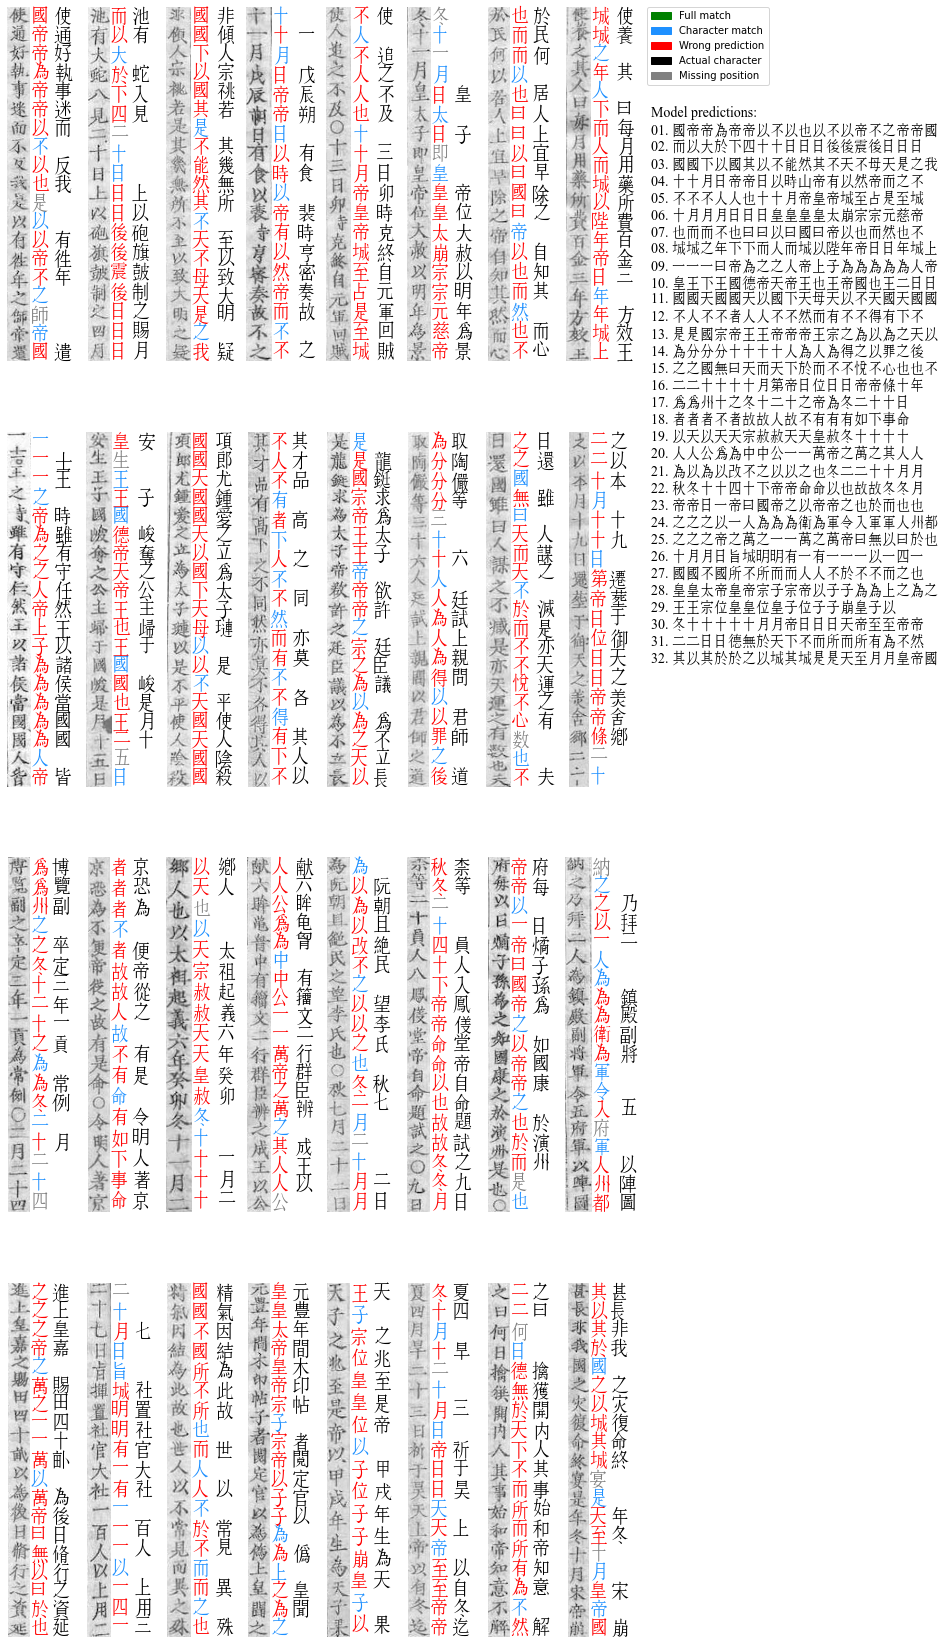

In [22]:
for idx, (batch_images, batch_tokens) in enumerate(valid_tf_dataset.take(1)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels = data_handler.tokens2texts(batch_tokens)
    pred_tokens = reset_model.predict(batch_images)
    pred_labels = data_handler.tokens2texts(pred_tokens)
    
    visualize_images_labels(
        img_paths = dataset.img_paths[idxs_in_batch], 
        labels = labels, 
        pred_labels = pred_labels,
        figsize = (11.6, 30),
        subplot_size = (4, 8),
        legend_loc = (3.8, 4.38),
        annotate_loc = (4, 2.75),
        font_path = FONT_PATH, 
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

## On random image

In [23]:
random_path = '../囷𦝄苔惮󰞺𧍋𦬑囊.jpg'
random_label = '囷𦝄苔惮󰞺𧍋𦬑囊'
random_image = data_handler.process_image(random_path)
pred_tokens = reset_model.predict(tf.expand_dims(random_image, axis=0))
pred_labels = data_handler.tokens2texts(pred_tokens)

Predicted text: 𠊛𠊛買別細𢚸𢚸愁


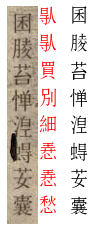

In [24]:
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    font_path = FONT_PATH, 
)
print('Predicted text:', ''.join(pred_labels))

# Detail evaluation

In [25]:
import pandas as pd
from evaluator import Evaluator
GT10_TRANSCRIPTS_PATH = f'{DATASET_DIR}/Validate_gt10.txt'
LTE10_TRANSCRIPTS_PATH = f'{DATASET_DIR}/Validate_lte10.txt'

In [26]:
gt10_evaluator = Evaluator(reset_model, DATASET_DIR, GT10_TRANSCRIPTS_PATH)
lte10_evaluator = Evaluator(reset_model, DATASET_DIR, LTE10_TRANSCRIPTS_PATH)
df = pd.DataFrame([
    reset_model.evaluate(valid_tf_dataset, return_dict=True),
    gt10_evaluator.evaluate(data_handler, BATCH_SIZE, drop_remainder=True),
    lte10_evaluator.evaluate(data_handler, BATCH_SIZE, drop_remainder=True),
])
df.index = ['Full', 'Length > 10', 'Length ≤ 10']
df

116/116 [==============================] - 15s 126ms/step - loss: 1.6344 - seq_acc: 0.0388 - char_acc: 0.3494 - lev_distance: 0.6058


,loss,seq_acc,char_acc,lev_distance
Full,1.224655,0.019068,0.232950,0.708923
Length > 10,4.772167,0.000000,0.187931,0.806201
Length ≤ 10,1.362206,0.038793,0.349396,0.605805
